# 1. Setup and Get Data

### 1.1 Install Dependencies and Setup

In [ ]:
!pip install labelme tensorflow opencv-python matplotlib albumentations

### 1.2 Collect Images Using OpenCV

In [5]:
import os
import time
import uuid
import cv2

In [3]:
IMAGES_PATH = os.path.join('data','images')
number_images = 30

In [7]:
cap = cv2.VideoCapture(0)
for imgnum in range(number_images):
    print('Collecting image {}'.format(imgnum))
    ret, frame = cap.read()
    imgname = os.path.join(IMAGES_PATH,f'{str(uuid.uuid1())}.jpg')
    cv2.imwrite(imgname, frame)
    cv2.imshow('frame', frame)
    time.sleep(0.5)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

### 1.3 Annotate Images with LabelMe

In [8]:
!labelme

2024-04-19 12:32:41,072 [INFO   ] __init__:get_config:67- Loading config file from: C:\Users\Dhayanithi\.labelmerc


# 2. Review Dataset and Build Image Loading Function

### 2.1 Import TF and Deps

In [7]:
import tensorflow as tf
import json
import numpy as np
from matplotlib import pyplot as plt

### 2.2 Limit GPU Memory Growth

In [10]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [11]:
tf.config.list_physical_devices('GPU')

[]

### 2.3 Load Image into TF Data Pipeline

In [12]:
images = tf.data.Dataset.list_files('data\\images\\*.jpg')

In [13]:
images.as_numpy_iterator().next()

b'data\\images\\b96af8c3-fe1a-11ee-a041-f889d2840d92.jpg'

In [14]:
def load_image(x): 
    byte_img = tf.io.read_file(x)
    img = tf.io.decode_jpeg(byte_img)
    return img

In [15]:
images = images.map(load_image)

In [16]:
images.as_numpy_iterator().next()

array([[[ 75,  85,  74],
        [ 84,  94,  85],
        [ 93, 104,  96],
        ...,
        [106, 109, 118],
        [106, 106, 114],
        [105, 104, 112]],

       [[ 81,  91,  83],
        [ 88,  98,  90],
        [ 94, 105,  99],
        ...,
        [105, 108, 115],
        [106, 106, 114],
        [105, 104, 110]],

       [[ 87,  96,  95],
        [ 90,  99,  98],
        [ 93, 103, 104],
        ...,
        [105, 108, 113],
        [106, 107, 112],
        [106, 105, 110]],

       ...,

       [[ 79, 116, 160],
        [ 77, 116, 159],
        [ 78, 115, 159],
        ...,
        [ 44,  46,  61],
        [ 45,  46,  64],
        [ 46,  47,  65]],

       [[ 82, 117, 159],
        [ 78, 115, 157],
        [ 79, 114, 156],
        ...,
        [ 45,  44,  58],
        [ 47,  46,  62],
        [ 48,  47,  63]],

       [[ 83, 118, 160],
        [ 80, 115, 157],
        [ 78, 113, 155],
        ...,
        [ 46,  46,  58],
        [ 47,  46,  60],
        [ 49,  48,  62]]

In [17]:
type(images)

tensorflow.python.data.ops.map_op._MapDataset

### 2.4 View Raw Images with Matplotlib

In [18]:
image_generator = images.batch(4).as_numpy_iterator()

In [19]:
plot_images = image_generator.next()

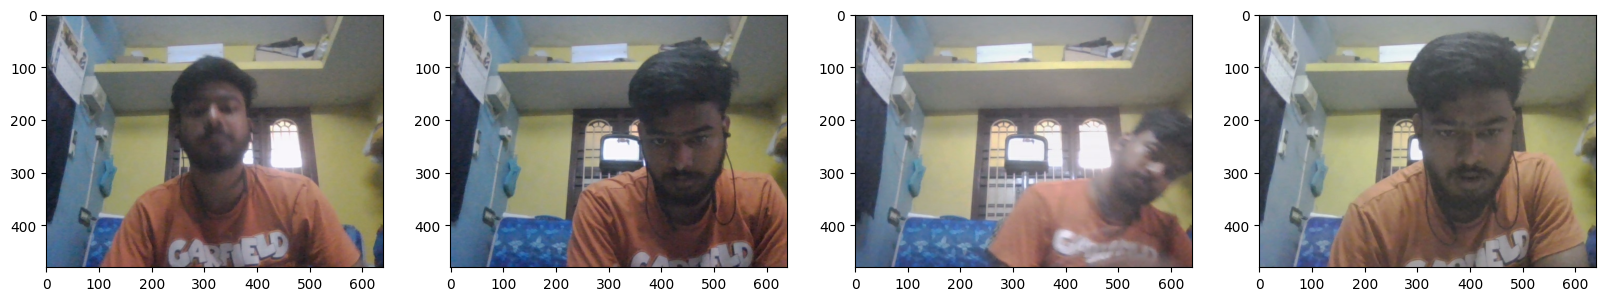

In [20]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, image in enumerate(plot_images):
    ax[idx].imshow(image) 
plt.show()

# 3. Partition Unaugmented Data

### 3.1 MANUALLY SPLT DATA INTO TRAIN TEST AND VAL

In [21]:
90*.7 # 63 to train

62.99999999999999

In [22]:
90*.15 # 14 and 13 to test and val

13.5

### 3.2 Move the Matching Labels

In [23]:
for folder in ['train','test','val']:
    for file in os.listdir(os.path.join('data', folder, 'images')):
        
        filename = file.split('.')[0]+'.json'
        existing_filepath = os.path.join('data','labels', filename)
        if os.path.exists(existing_filepath): 
            new_filepath = os.path.join('data',folder,'labels',filename)
            os.replace(existing_filepath, new_filepath)      

# 4. Apply Image Augmentation on Images and Labels using Albumentations

### 4.1 Setup Albumentations Transform Pipeline

In [24]:
import albumentations as alb

In [25]:
augmentor = alb.Compose([alb.RandomCrop(width=450, height=450), 
                         alb.HorizontalFlip(p=0.5), 
                         alb.RandomBrightnessContrast(p=0.2),
                         alb.RandomGamma(p=0.2), 
                         alb.RGBShift(p=0.2), 
                         alb.VerticalFlip(p=0.5)], 
                       bbox_params=alb.BboxParams(format='albumentations', 
                                                  label_fields=['class_labels']))

### 4.2 Load a Test Image and Annotation with OpenCV and JSON

In [26]:
img = cv2.imread(os.path.join('data','train', 'images','8689664d-fe1a-11ee-8d3c-f889d2840d92.jpg'))

In [27]:
img

array([[[127, 105,  93],
        [128, 109,  96],
        [129, 111, 100],
        ...,
        [106, 106, 106],
        [106, 104, 104],
        [104, 102, 102]],

       [[126, 104,  92],
        [127, 108,  95],
        [127, 111,  99],
        ...,
        [106, 106, 106],
        [106, 104, 104],
        [104, 102, 102]],

       [[121, 102,  89],
        [122, 105,  92],
        [125, 109,  97],
        ...,
        [108, 106, 106],
        [108, 103, 104],
        [106, 101, 102]],

       ...,

       [[155, 114,  92],
        [153, 115,  91],
        [155, 114,  91],
        ...,
        [ 69,  48,  40],
        [ 69,  49,  38],
        [ 69,  49,  38]],

       [[154, 114,  95],
        [152, 115,  93],
        [154, 115,  93],
        ...,
        [ 67,  48,  40],
        [ 67,  48,  40],
        [ 67,  48,  40]],

       [[153, 116,  96],
        [153, 116,  96],
        [153, 116,  94],
        ...,
        [ 66,  49,  40],
        [ 66,  49,  40],
        [ 66,  49,  40]]

In [28]:
with open(os.path.join('data', 'train', 'labels', '8689664d-fe1a-11ee-8d3c-f889d2840d92.json'), 'r') as f:
    label = json.load(f)

In [29]:
label['shapes'][0]['points']

[[264.1666666666667, 66.11111111111111],
 [440.8333333333333, 303.8888888888889]]

### 4.3 Extract Coordinates and Rescale to Match Image Resolution

In [30]:
coords = [0,0,0,0]
coords[0] = label['shapes'][0]['points'][0][0]
coords[1] = label['shapes'][0]['points'][0][1]
coords[2] = label['shapes'][0]['points'][1][0]
coords[3] = label['shapes'][0]['points'][1][1]

In [31]:
coords

[264.1666666666667, 66.11111111111111, 440.8333333333333, 303.8888888888889]

In [32]:
coords = list(np.divide(coords, [640,480,640,480]))

In [33]:
coords

[0.4127604166666667,
 0.13773148148148148,
 0.6888020833333333,
 0.6331018518518519]

### 4.4 Apply Augmentations and View Results

In [34]:
augmented = augmentor(image=img, bboxes=[coords], class_labels=['face'])

In [35]:
augmented['bboxes'][0][2:]

(0.7196296296296296, 0.8797530864197531)

In [36]:
augmented['bboxes']

[(0.32703703703703724,
  0.351358024691358,
  0.7196296296296296,
  0.8797530864197531)]

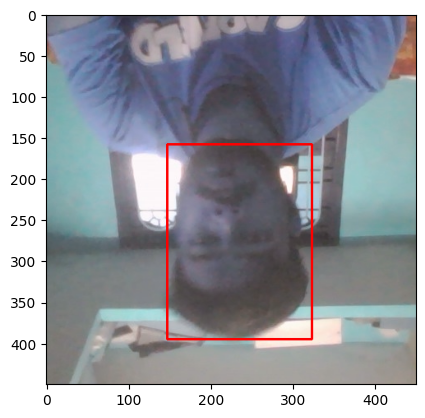

In [37]:
cv2.rectangle(augmented['image'], 
              tuple(np.multiply(augmented['bboxes'][0][:2], [450,450]).astype(int)),
              tuple(np.multiply(augmented['bboxes'][0][2:], [450,450]).astype(int)), 
                    (255,0,0), 2)

plt.imshow(augmented['image'])

# 5. Build and Run Augmentation Pipeline

### 5.1 Run Augmentation Pipeline

In [38]:
for partition in ['train','test','val']: 
    for image in os.listdir(os.path.join('data', partition, 'images')):
        img = cv2.imread(os.path.join('data', partition, 'images', image))

        coords = [0,0,0.00001,0.00001]
        label_path = os.path.join('data', partition, 'labels', f'{image.split(".")[0]}.json')
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                label = json.load(f)

            coords[0] = label['shapes'][0]['points'][0][0]
            coords[1] = label['shapes'][0]['points'][0][1]
            coords[2] = label['shapes'][0]['points'][1][0]
            coords[3] = label['shapes'][0]['points'][1][1]
            coords = list(np.divide(coords, [640,480,640,480]))

        try: 
            for x in range(60):
                augmented = augmentor(image=img, bboxes=[coords], class_labels=['face'])
                cv2.imwrite(os.path.join('aug_data', partition, 'images', f'{image.split(".")[0]}.{x}.jpg'), augmented['image'])

                annotation = {}
                annotation['image'] = image

                if os.path.exists(label_path):
                    if len(augmented['bboxes']) == 0: 
                        annotation['bbox'] = [0,0,0,0]
                        annotation['class'] = 0 
                    else: 
                        annotation['bbox'] = augmented['bboxes'][0]
                        annotation['class'] = 1
                else: 
                    annotation['bbox'] = [0,0,0,0]
                    annotation['class'] = 0 


                with open(os.path.join('aug_data', partition, 'labels', f'{image.split(".")[0]}.{x}.json'), 'w') as f:
                    json.dump(annotation, f)

        except Exception as e:
            print(e)

image must be numpy array type
x_max is less than or equal to x_min for bbox [0.6809895833333333, 0.7395833333333334, 0.2591145833333333, 0.10416666666666667, 'face'].


### 5.2 Load Augmented Images to Tensorflow Dataset

In [39]:
train_images = tf.data.Dataset.list_files('aug_data\\train\\images\\*.jpg', shuffle=False)
train_images = train_images.map(load_image)
train_images = train_images.map(lambda x: tf.image.resize(x, (120,120)))
train_images = train_images.map(lambda x: x/255)

In [40]:
test_images = tf.data.Dataset.list_files('aug_data\\test\\images\\*.jpg', shuffle=False)
test_images = test_images.map(load_image)
test_images = test_images.map(lambda x: tf.image.resize(x, (120,120)))
test_images = test_images.map(lambda x: x/255)

In [41]:
val_images = tf.data.Dataset.list_files('aug_data\\val\\images\\*.jpg', shuffle=False)
val_images = val_images.map(load_image)
val_images = val_images.map(lambda x: tf.image.resize(x, (120,120)))
val_images = val_images.map(lambda x: x/255)

In [42]:
train_images.as_numpy_iterator().next()

array([[[0.22156863, 0.25245097, 0.29313725],
        [0.21544118, 0.23210785, 0.30661765],
        [0.24779412, 0.25563726, 0.34289217],
        ...,
        [0.15900736, 0.09950981, 0.09675245],
        [0.18186274, 0.12303922, 0.09852941],
        [0.14368872, 0.08278187, 0.08431373]],

       [[0.21856618, 0.2382353 , 0.29993874],
        [0.22971813, 0.24295343, 0.3091299 ],
        [0.25563726, 0.26838234, 0.33688724],
        ...,
        [0.33909315, 0.29344362, 0.2920956 ],
        [0.19442402, 0.14050245, 0.1413603 ],
        [0.16525735, 0.10435049, 0.13952206]],

       [[0.20422794, 0.2341299 , 0.28523284],
        [0.21868873, 0.25778186, 0.30490196],
        [0.1778799 , 0.20876226, 0.28927696],
        ...,
        [0.37120098, 0.33639705, 0.33884802],
        [0.3259804 , 0.2863358 , 0.29056373],
        [0.17120098, 0.11286765, 0.15061274]],

       ...,

       [[0.44424018, 0.5099265 , 0.5884804 ],
        [0.5589461 , 0.59375   , 0.65159315],
        [0.5360907 , 0

# 6. Prepare Labels

### 6.1 Build Label Loading Function

In [43]:
def load_labels(label_path):
    with open(label_path.numpy(), 'r', encoding = "utf-8") as f:
        label = json.load(f)
        
    return [label['class']], label['bbox']

### 6.2 Load Labels to Tensorflow Dataset

In [44]:
train_labels = tf.data.Dataset.list_files('aug_data\\train\\labels\\*.json', shuffle=False)
train_labels = train_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [45]:
test_labels = tf.data.Dataset.list_files('aug_data\\test\\labels\\*.json', shuffle=False)
test_labels = test_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [46]:
val_labels = tf.data.Dataset.list_files('aug_data\\val\\labels\\*.json', shuffle=False)
val_labels = val_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [47]:
train_labels.as_numpy_iterator().next()

(array([1], dtype=uint8),
 array([0.4976, 0.267 , 0.994 , 0.9683], dtype=float16))

# 7. Combine Label and Image Samples

### 7.1 Check Partition Lengths

In [48]:
len(train_images), len(train_labels), len(test_images), len(test_labels), len(val_images), len(val_labels)

(3780, 3780, 840, 840, 720, 720)

### 7.2 Create Final Datasets (Images/Labels)

In [49]:
train = tf.data.Dataset.zip((train_images, train_labels))
train = train.shuffle(5000)
train = train.batch(8)
train = train.prefetch(4)

In [50]:
test = tf.data.Dataset.zip((test_images, test_labels))
test = test.shuffle(1300)
test = test.batch(8)
test = test.prefetch(4)

In [51]:
val = tf.data.Dataset.zip((val_images, val_labels))
val = val.shuffle(1000)
val = val.batch(8)
val = val.prefetch(4)

In [52]:
train.as_numpy_iterator().next()[1]

(array([[1],
        [0],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1]], dtype=uint8),
 array([[0.5103 , 0.2576 , 1.     , 0.9365 ],
        [0.     , 0.     , 0.     , 0.     ],
        [0.     , 0.4392 , 0.09814, 0.8306 ],
        [0.2622 , 0.3394 , 0.62   , 0.8345 ],
        [0.2769 , 0.2318 , 0.7573 , 0.8403 ],
        [0.     , 0.4065 , 0.0636 , 0.931  ],
        [0.5464 , 0.0642 , 0.987  , 0.748  ],
        [0.2394 , 0.1165 , 0.743  , 0.7686 ]], dtype=float16))

### 7.3 View Images and Annotations

In [53]:
data_samples = train.as_numpy_iterator()

In [59]:
res = data_samples.next()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


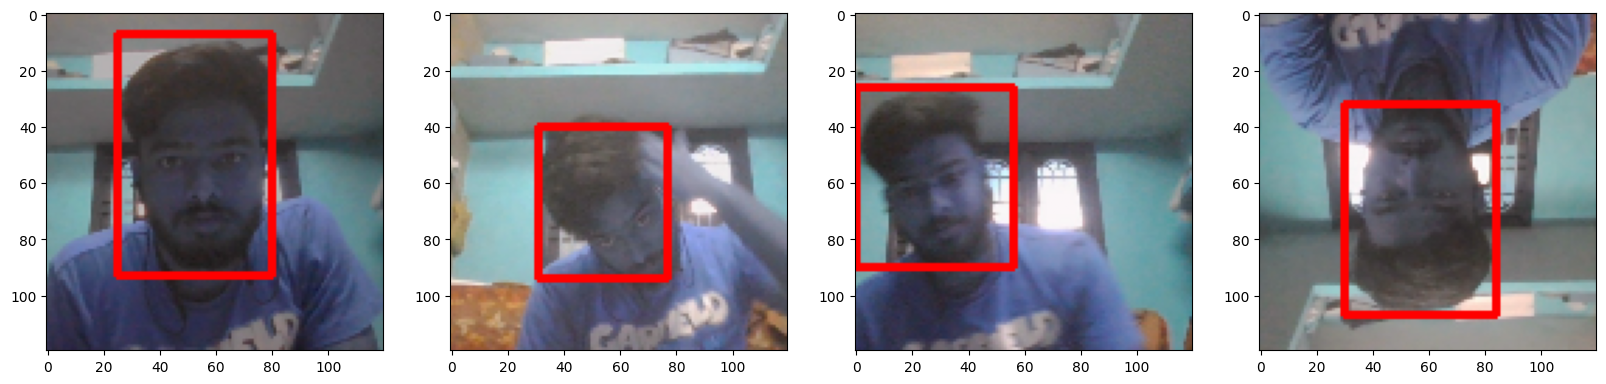

In [60]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample_image = res[0][idx]
    sample_coords = res[1][1][idx]

    # Convert to BGR color format and make a copy
    sample_image = cv2.cvtColor(sample_image, cv2.COLOR_RGB2BGR).copy()
    
    cv2.rectangle(sample_image, 
                  tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                  tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)), 
                  (255,0,0), 2)

    ax[idx].imshow(sample_image)


# 8. Build Deep Learning using the Functional API

### 8.1 Import Layers and Base Network

In [61]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Dense, GlobalMaxPooling2D
from tensorflow.keras.applications import VGG16

### 8.2 Download VGG16

In [62]:
vgg = VGG16(include_top=False)

58889256/58889256 [==============================] - 10s 0us/step


In [63]:
vgg.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

### 8.3 Build instance of Network

In [64]:
def build_model(): 
    input_layer = Input(shape=(120,120,3))
    
    vgg = VGG16(include_top=False)(input_layer)

    # Classification Model  
    f1 = GlobalMaxPooling2D()(vgg)
    class1 = Dense(2048, activation='relu')(f1)
    class2 = Dense(1, activation='sigmoid')(class1)
    
    # Bounding box model
    f2 = GlobalMaxPooling2D()(vgg)
    regress1 = Dense(2048, activation='relu')(f2)
    regress2 = Dense(4, activation='sigmoid')(regress1)
    
    facetracker = Model(inputs=input_layer, outputs=[class2, regress2])
    return facetracker

### 8.4 Test out Neural Network

In [65]:
facetracker = build_model()

In [66]:
facetracker.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 120, 120, 3)]        0         []                            
                                                                                                  
 vgg16 (Functional)          (None, None, None, 512)      1471468   ['input_2[0][0]']             
                                                          8                                       
                                                                                                  
 global_max_pooling2d (Glob  (None, 512)                  0         ['vgg16[0][0]']               
 alMaxPooling2D)                                                                                  
                                                                                              

In [67]:
X, y = train.as_numpy_iterator().next()

In [68]:
X.shape

(8, 120, 120, 3)

In [69]:
classes, coords = facetracker.predict(X)

1/1 [==============================] - 0s 288ms/step


In [70]:
classes, coords

(array([[0.5957097 ],
        [0.5829525 ],
        [0.5783861 ],
        [0.61313677],
        [0.60341716],
        [0.5735268 ],
        [0.57725406],
        [0.5985201 ]], dtype=float32),
 array([[0.5933634 , 0.680929  , 0.5782696 , 0.5492022 ],
        [0.50732815, 0.7063644 , 0.6379134 , 0.58390605],
        [0.6819641 , 0.7003783 , 0.71150905, 0.53300864],
        [0.5650985 , 0.6312633 , 0.58039653, 0.487331  ],
        [0.5273968 , 0.6730918 , 0.5836137 , 0.501346  ],
        [0.5684708 , 0.5876004 , 0.59145916, 0.5214613 ],
        [0.62327003, 0.5406898 , 0.5494667 , 0.5029079 ],
        [0.5910707 , 0.5127246 , 0.5544583 , 0.53802663]], dtype=float32))

# 9. Define Losses and Optimizers

### 9.1 Define Optimizer and LR

In [73]:
# Importing the legacy optimizer
from tensorflow.keras.optimizers import legacy

# Calculate lr_decay
batches_per_epoch = len(train)
lr_decay = (1. / 0.75 - 1) / batches_per_epoch

# Define the optimizer using the legacy optimizer
opt = legacy.Adam(learning_rate=0.0001, decay=lr_decay)



### 9.2 Create Localization Loss and Classification Loss

In [74]:
def localization_loss(y_true, yhat):            
    delta_coord = tf.reduce_sum(tf.square(y_true[:,:2] - yhat[:,:2]))
                  
    h_true = y_true[:,3] - y_true[:,1] 
    w_true = y_true[:,2] - y_true[:,0] 

    h_pred = yhat[:,3] - yhat[:,1] 
    w_pred = yhat[:,2] - yhat[:,0] 
    
    delta_size = tf.reduce_sum(tf.square(w_true - w_pred) + tf.square(h_true-h_pred))
    
    return delta_coord + delta_size

In [75]:
classloss = tf.keras.losses.BinaryCrossentropy()
regressloss = localization_loss

### 9.3 Test out Loss Metrics

In [76]:
localization_loss(y[1], coords)

<tf.Tensor: shape=(), dtype=float32, numpy=6.2396765>

In [77]:
classloss(y[0], classes)

<tf.Tensor: shape=(), dtype=float32, numpy=0.56621337>

In [78]:
regressloss(y[1], coords)

<tf.Tensor: shape=(), dtype=float32, numpy=6.2396765>

# 10. Train Neural Network

### 10.1 Create Custom Model Class

In [79]:
class FaceTracker(Model): 
    def __init__(self, eyetracker,  **kwargs): 
        super().__init__(**kwargs)
        self.model = eyetracker

    def compile(self, opt, classloss, localizationloss, **kwargs):
        super().compile(**kwargs)
        self.closs = classloss
        self.lloss = localizationloss
        self.opt = opt
    
    def train_step(self, batch, **kwargs): 
        
        X, y = batch
        
        with tf.GradientTape() as tape: 
            classes, coords = self.model(X, training=True)
            
            batch_classloss = self.closs(y[0], classes)
            batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
            
            total_loss = batch_localizationloss+0.5*batch_classloss
            
            grad = tape.gradient(total_loss, self.model.trainable_variables)
        
        opt.apply_gradients(zip(grad, self.model.trainable_variables))
        
        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}
    
    def test_step(self, batch, **kwargs): 
        X, y = batch
        
        classes, coords = self.model(X, training=False)
        
        batch_classloss = self.closs(y[0], classes)
        batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
        total_loss = batch_localizationloss+0.5*batch_classloss
        
        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}
        
    def call(self, X, **kwargs): 
        return self.model(X, **kwargs)

In [80]:
model = FaceTracker(facetracker)

In [81]:
model.compile(opt, classloss, regressloss)

### 10.2 Train

In [82]:
logdir='logs'

In [83]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [84]:
hist = model.fit(train, epochs=10, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/10
473/473 [==============================] - 413s 867ms/step - total_loss: 0.4016 - class_loss: 0.1054 - regress_loss: 0.3489 - val_total_loss: 0.0505 - val_class_loss: 0.0073 - val_regress_loss: 0.0469
Epoch 2/10
473/473 [==============================] - 411s 865ms/step - total_loss: 0.0895 - class_loss: 0.0208 - regress_loss: 0.0791 - val_total_loss: 0.0762 - val_class_loss: 0.0082 - val_regress_loss: 0.0721
Epoch 3/10
473/473 [==============================] - 415s 874ms/step - total_loss: 0.0431 - class_loss: 0.0100 - regress_loss: 0.0381 - val_total_loss: 0.0916 - val_class_loss: 0.0074 - val_regress_loss: 0.0879
Epoch 4/10
473/473 [==============================] - 401s 845ms/step - total_loss: 0.0447 - class_loss: 0.0103 - regress_loss: 0.0396 - val_total_loss: 0.0385 - val_class_loss: 6.2815e-04 - val_regress_loss: 0.0382
Epoch 5/10
473/473 [==============================] - 402s 846ms/step - total_loss: 0.0270 - class_loss: 0.0066 - regress_loss: 0.0237 - val_total_l

### 10.3 Plot Performance

In [85]:
hist.history

{'total_loss': [0.03286934271454811,
  0.00911058858036995,
  0.008027981035411358,
  0.90834641456604,
  0.00407490273937583,
  0.003962277434766293,
  0.0013913814909756184,
  0.007759225554764271,
  0.00791547354310751,
  0.003254119772464037],
 'class_loss': [0.00024199880135711282,
  0.00036551494849845767,
  6.452521483879536e-05,
  0.5354490876197815,
  3.406483301660046e-05,
  6.988673248997657e-06,
  9.937172580976039e-05,
  0.00010223846038570628,
  3.580898919608444e-05,
  4.142544639762491e-06],
 'regress_loss': [0.03274834156036377,
  0.008927831426262856,
  0.007995718158781528,
  0.6406218409538269,
  0.0040578702464699745,
  0.003958783112466335,
  0.0013416956644505262,
  0.007708106189966202,
  0.007897568866610527,
  0.003252048511058092],
 'val_total_loss': [0.050491683185100555,
  0.07616199553012848,
  0.09156510978937149,
  0.03850318491458893,
  0.038144201040267944,
  0.17212744057178497,
  0.6617562174797058,
  0.25615885853767395,
  0.02720562554895878,
  0.0

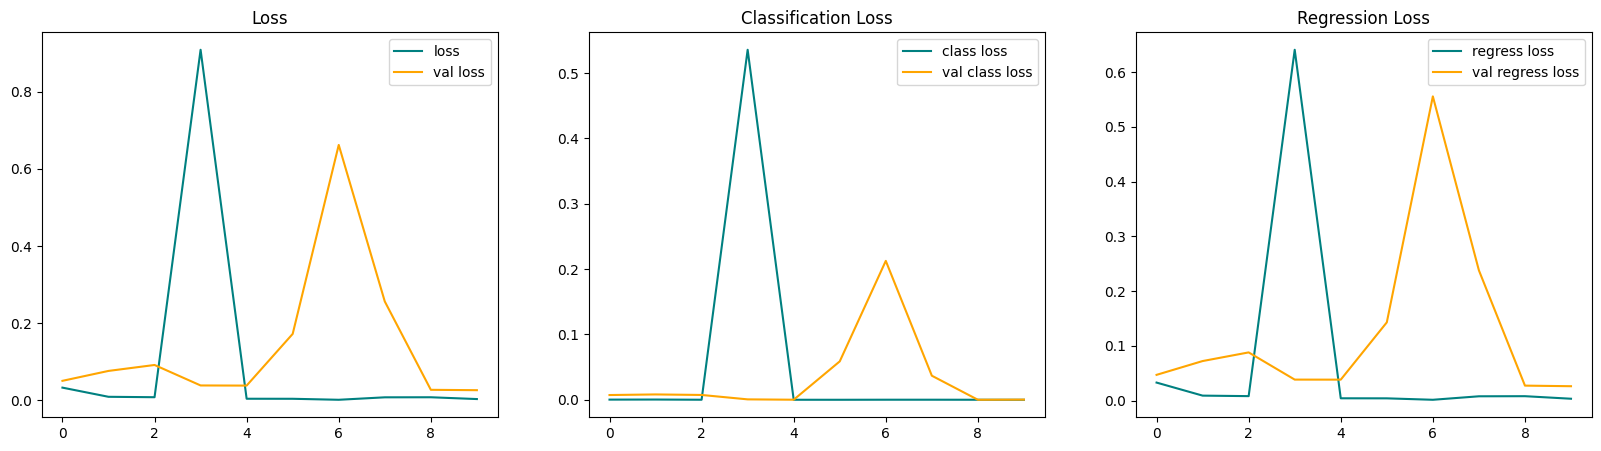

In [86]:
fig, ax = plt.subplots(ncols=3, figsize=(20,5))

ax[0].plot(hist.history['total_loss'], color='teal', label='loss')
ax[0].plot(hist.history['val_total_loss'], color='orange', label='val loss')
ax[0].title.set_text('Loss')
ax[0].legend()

ax[1].plot(hist.history['class_loss'], color='teal', label='class loss')
ax[1].plot(hist.history['val_class_loss'], color='orange', label='val class loss')
ax[1].title.set_text('Classification Loss')
ax[1].legend()

ax[2].plot(hist.history['regress_loss'], color='teal', label='regress loss')
ax[2].plot(hist.history['val_regress_loss'], color='orange', label='val regress loss')
ax[2].title.set_text('Regression Loss')
ax[2].legend()

plt.show()

# 11. Make Predictions

### 11.1 Make Predictions on Test Set

In [87]:
test_data = test.as_numpy_iterator()

In [88]:
test_sample = test_data.next()

In [89]:
yhat = facetracker.predict(test_sample[0])

1/1 [==============================] - 0s 162ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


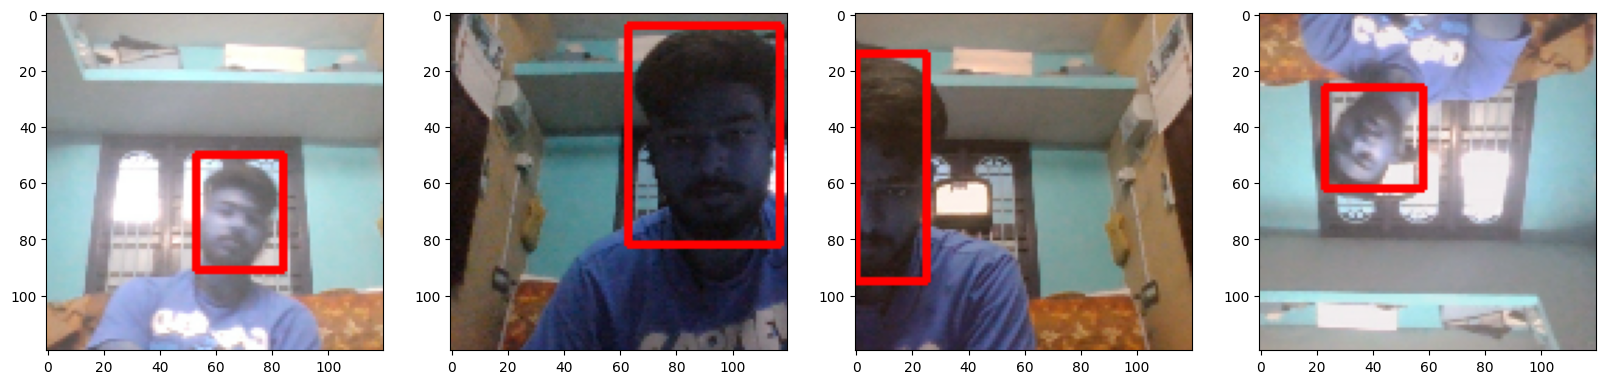

In [91]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample_image = test_sample[0][idx]
    sample_coords = yhat[1][idx]

    # Convert to BGR color format and make a copy
    sample_image = cv2.cvtColor(sample_image, cv2.COLOR_RGB2BGR).copy()
    
    if yhat[0][idx] > 0.9:
        cv2.rectangle(sample_image, 
                      tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)), 
                      (255,0,0), 2)
    
    ax[idx].imshow(sample_image)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


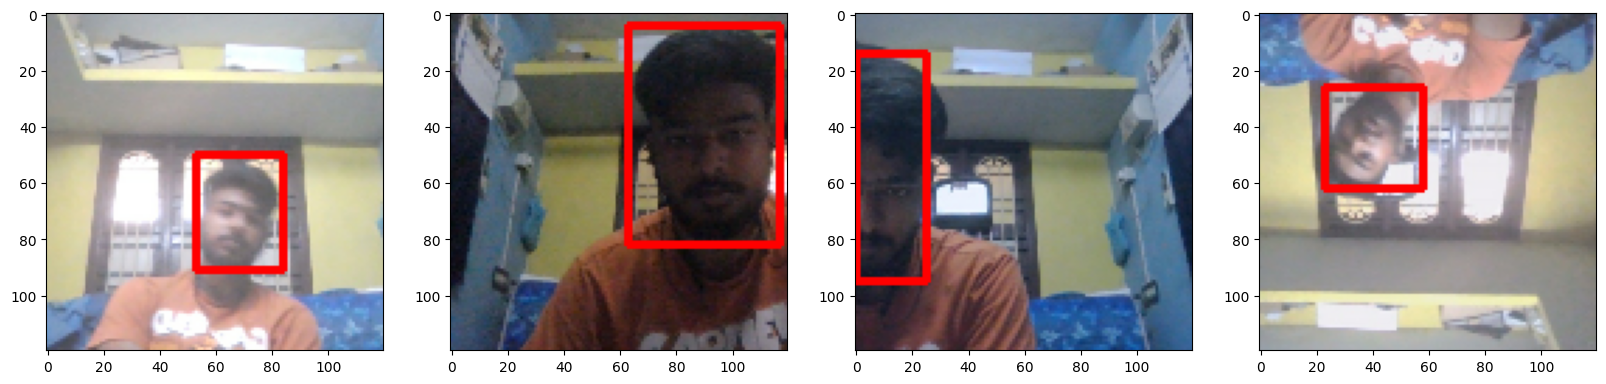

In [92]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample_image = test_sample[0][idx].copy()  # Make a copy of the original image
    sample_coords = yhat[1][idx]

    if yhat[0][idx] > 0.9:
        cv2.rectangle(sample_image, 
                      tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)), 
                      (255,0,0), 2)
    
    ax[idx].imshow(sample_image)


### 11.2 Save the Model

In [2]:
from tensorflow.keras.models import load_model

In [94]:
facetracker.save('facetracker.h5')

C:\Users\Dhayanithi\Desktop\MLOPS GIT\env\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [3]:
facetracker = load_model('facetracker.h5')

### 11.3 Real Time Detection

In [ ]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    _ , frame = cap.read()
    frame = frame[50:500, 50:500,:]
    
    rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    resized = tf.image.resize(rgb, (120,120))
    
    yhat = facetracker.predict(np.expand_dims(resized/255,0))
    sample_coords = yhat[1][0]
    
    if yhat[0] > 0.5: 
        # Controls the main rectangle
        cv2.rectangle(frame, 
                      tuple(np.multiply(sample_coords[:2], [450,450]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [450,450]).astype(int)), 
                            (255,0,0), 2)
        # Controls the label rectangle
        cv2.rectangle(frame, 
                      tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int), 
                                    [0,-30])),
                      tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),
                                    [80,0])), 
                            (255,0,0), -1)
        
        # Controls the text rendered
        cv2.putText(frame, 'face', tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),
                                               [0,-5])),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
    
    cv2.imshow('EyeTrack', frame)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()